In [130]:
import pandas as pd
df = pd.read_csv("train.csv")

df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [131]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [132]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [133]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

In [134]:
df["Age"] = df["Age"].fillna(df["Age"].mean())

In [ ]:
df["Embarked"] = df["Embarked"].map({"S" : 0,"C" :1 ,"Q": 2})

In [ ]:
dfd = df.drop(columns=["Cabin","Name","Ticket","Fare"])

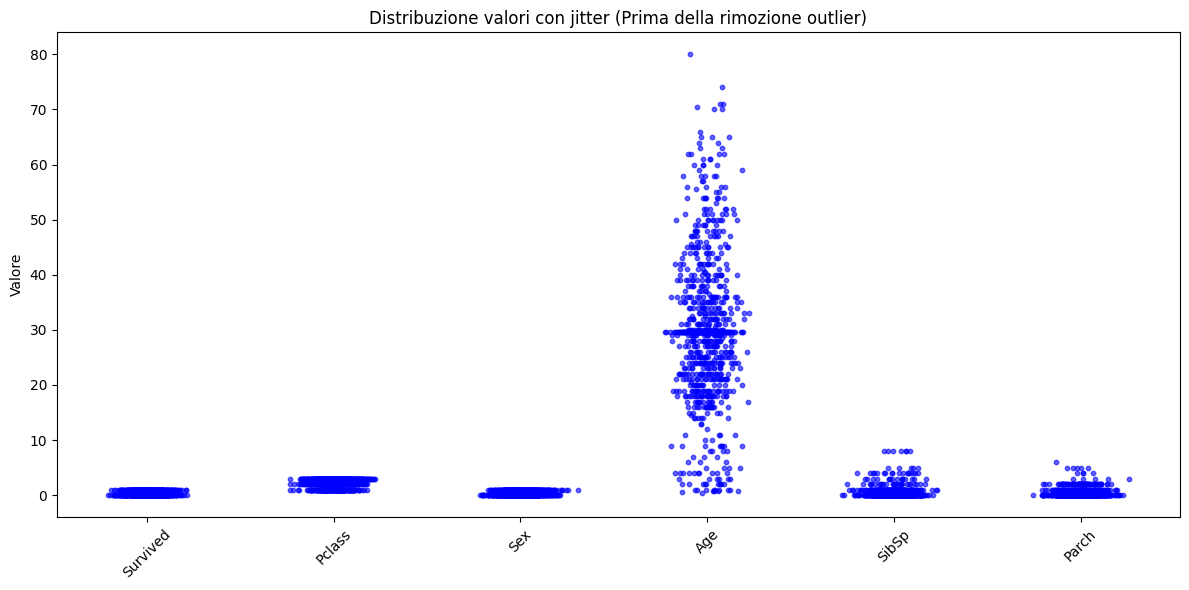

In [136]:
import matplotlib.pyplot as plt
import numpy as np


numeric_cols = dfd.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != "PassengerId"]

plt.figure(figsize=(12, 6))

for i, col in enumerate(numeric_cols):
    data = dfd[col].dropna()  
    if len(data) == 0:
        continue
    
    # Jitter sull'asse x
    x = np.random.normal(i, 0.08, size=len(data))
    plt.scatter(x, data.values, alpha=0.6, s=10, color='blue')

plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.title("Distribuzione valori con jitter (Prima della rimozione outlier)")
plt.ylabel("Valore")
plt.tight_layout()
plt.show()


In [137]:
dfd.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
dtype: int64

In [138]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    dfd[col] = np.where(dfd[col].between(lower, upper), dfd[col], np.nan)

In [139]:
from sklearn.model_selection import train_test_split


X = dfd[numeric_cols].copy()
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

X = dfd[numeric_cols].copy()          
y = df['Survived']                     

X = X.fillna(X.median())


In [141]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_jobs': -1,
        'random_state': 42,
        'tree_method': 'hist', 
        'device': 'cuda'    
    }

    model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return scores.mean()


study = optuna.create_study(direction='maximize', study_name="XGBoost_Titanic")
study.optimize(objective, n_trials=50, show_progress_bar=True)


print("\n--- Risultati Ottimizzazione ---")
print(f"Miglior Trial (Tentativo #{study.best_trial.number})")
print(f"Accuratezza Migliore (CV): {study.best_value:.4f}")
print("Migliori Iperparametri:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)
final_acc = final_model.score(X_test, y_test)
print(f"\nAccuratezza Finale sul Test Set: {final_acc:.4f}")


[I 2025-12-05 10:57:48,572] A new study created in memory with name: XGBoost_Titanic
Best trial: 0. Best value: 1:   2%|▏         | 1/50 [00:03<02:27,  3.01s/it]

[I 2025-12-05 10:57:51,581] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 642, 'learning_rate': 0.06886084271965011, 'max_depth': 6, 'subsample': 0.5607116409550553, 'colsample_bytree': 0.9034062113065687, 'reg_alpha': 0.8097292489621666, 'reg_lambda': 3.871178491867803e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:   4%|▍         | 2/50 [00:04<01:31,  1.92s/it]

[I 2025-12-05 10:57:52,730] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 180, 'learning_rate': 0.028056087997512455, 'max_depth': 7, 'subsample': 0.9760702180225621, 'colsample_bytree': 0.9390883037932465, 'reg_alpha': 0.9049979982627797, 'reg_lambda': 6.704442379101076e-08}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:   6%|▌         | 3/50 [00:07<02:07,  2.72s/it]

[I 2025-12-05 10:57:56,397] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 775, 'learning_rate': 0.042341229626796775, 'max_depth': 7, 'subsample': 0.7427041849132986, 'colsample_bytree': 0.9386185547468362, 'reg_alpha': 2.1072801002058167e-07, 'reg_lambda': 0.007037856489846467}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:   8%|▊         | 4/50 [00:09<01:50,  2.41s/it]

[I 2025-12-05 10:57:58,328] Trial 3 finished with value: 0.8300600807643062 and parameters: {'n_estimators': 219, 'learning_rate': 0.0015696240497879647, 'max_depth': 7, 'subsample': 0.6860031603725925, 'colsample_bytree': 0.5602961110463115, 'reg_alpha': 0.5789049076158521, 'reg_lambda': 0.2870571247371829}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  10%|█         | 5/50 [00:13<02:11,  2.92s/it]

[I 2025-12-05 10:58:02,149] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 589, 'learning_rate': 0.0274248357416873, 'max_depth': 10, 'subsample': 0.6466704079366064, 'colsample_bytree': 0.6037811346890287, 'reg_alpha': 4.411105428281135e-05, 'reg_lambda': 1.450003368784493}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  12%|█▏        | 6/50 [00:16<02:12,  3.02s/it]

[I 2025-12-05 10:58:05,368] Trial 5 finished with value: 1.0 and parameters: {'n_estimators': 533, 'learning_rate': 0.013116674791888506, 'max_depth': 6, 'subsample': 0.5923021036895786, 'colsample_bytree': 0.855467061560006, 'reg_alpha': 6.960557454111618, 'reg_lambda': 1.9615773485237938e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  14%|█▍        | 7/50 [00:18<01:53,  2.65s/it]

[I 2025-12-05 10:58:07,259] Trial 6 finished with value: 1.0 and parameters: {'n_estimators': 187, 'learning_rate': 0.027398208232651027, 'max_depth': 5, 'subsample': 0.9250131557643668, 'colsample_bytree': 0.7094217070313384, 'reg_alpha': 1.551247853471695e-05, 'reg_lambda': 4.0590260949285335e-05}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  16%|█▌        | 8/50 [00:20<01:45,  2.51s/it]

[I 2025-12-05 10:58:09,472] Trial 7 finished with value: 1.0 and parameters: {'n_estimators': 427, 'learning_rate': 0.08382640811135385, 'max_depth': 7, 'subsample': 0.9852567850891715, 'colsample_bytree': 0.685972534239678, 'reg_alpha': 0.002364437284900507, 'reg_lambda': 0.00819007034104275}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  18%|█▊        | 9/50 [00:24<01:55,  2.82s/it]

[I 2025-12-05 10:58:12,964] Trial 8 finished with value: 1.0 and parameters: {'n_estimators': 533, 'learning_rate': 0.00610010238153591, 'max_depth': 5, 'subsample': 0.6347206880478726, 'colsample_bytree': 0.8970064740404264, 'reg_alpha': 0.000630058684250807, 'reg_lambda': 0.8855740935105461}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  20%|██        | 10/50 [00:28<02:07,  3.18s/it]

[I 2025-12-05 10:58:16,956] Trial 9 finished with value: 1.0 and parameters: {'n_estimators': 359, 'learning_rate': 0.0012204273734133248, 'max_depth': 5, 'subsample': 0.9192348984450949, 'colsample_bytree': 0.6769948142489206, 'reg_alpha': 1.5265223325965929e-06, 'reg_lambda': 2.2933453825766014e-06}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  22%|██▏       | 11/50 [00:32<02:15,  3.46s/it]

[I 2025-12-05 10:58:21,064] Trial 10 finished with value: 1.0 and parameters: {'n_estimators': 957, 'learning_rate': 0.2927005276887218, 'max_depth': 3, 'subsample': 0.5098700840689083, 'colsample_bytree': 0.8143916578535357, 'reg_alpha': 0.023172895960068007, 'reg_lambda': 1.2922509613984727e-05}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  24%|██▍       | 12/50 [00:35<02:09,  3.40s/it]

[I 2025-12-05 10:58:24,318] Trial 11 finished with value: 1.0 and parameters: {'n_estimators': 733, 'learning_rate': 0.11942410435866883, 'max_depth': 9, 'subsample': 0.8227019234699038, 'colsample_bytree': 0.9917812819009835, 'reg_alpha': 0.09118666609713436, 'reg_lambda': 1.038618657165081e-08}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  26%|██▌       | 13/50 [00:40<02:22,  3.85s/it]

[I 2025-12-05 10:58:29,192] Trial 12 finished with value: 1.0 and parameters: {'n_estimators': 773, 'learning_rate': 0.005766528225897394, 'max_depth': 8, 'subsample': 0.848020465698627, 'colsample_bytree': 0.7861782638101249, 'reg_alpha': 8.442902240866758, 'reg_lambda': 1.1446166262391385e-08}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  28%|██▊       | 14/50 [00:41<01:43,  2.87s/it]

[I 2025-12-05 10:58:29,800] Trial 13 finished with value: 1.0 and parameters: {'n_estimators': 106, 'learning_rate': 0.08861970133773606, 'max_depth': 3, 'subsample': 0.5002046519614234, 'colsample_bytree': 0.9851335821199501, 'reg_alpha': 1.2946312686477472e-08, 'reg_lambda': 5.096983932503355e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  30%|███       | 15/50 [00:42<01:26,  2.46s/it]

[I 2025-12-05 10:58:31,326] Trial 14 finished with value: 1.0 and parameters: {'n_estimators': 352, 'learning_rate': 0.1997435790316173, 'max_depth': 6, 'subsample': 0.7673831209836918, 'colsample_bytree': 0.9018574719794205, 'reg_alpha': 0.16534553919414596, 'reg_lambda': 1.112018399879303e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  32%|███▏      | 16/50 [00:46<01:38,  2.88s/it]

[I 2025-12-05 10:58:35,186] Trial 15 finished with value: 1.0 and parameters: {'n_estimators': 639, 'learning_rate': 0.011010140725481727, 'max_depth': 8, 'subsample': 0.9980183773975744, 'colsample_bytree': 0.839875824572889, 'reg_alpha': 0.008143250782299093, 'reg_lambda': 0.00035201786707555886}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  34%|███▍      | 17/50 [00:50<01:46,  3.24s/it]

[I 2025-12-05 10:58:39,253] Trial 16 finished with value: 1.0 and parameters: {'n_estimators': 923, 'learning_rate': 0.046430872839578946, 'max_depth': 4, 'subsample': 0.582167089260041, 'colsample_bytree': 0.923479625374537, 'reg_alpha': 0.8359552399672686, 'reg_lambda': 4.162842730641138e-06}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  36%|███▌      | 18/50 [00:52<01:32,  2.88s/it]

[I 2025-12-05 10:58:41,296] Trial 17 finished with value: 1.0 and parameters: {'n_estimators': 436, 'learning_rate': 0.054443501620512084, 'max_depth': 8, 'subsample': 0.7334206839689996, 'colsample_bytree': 0.7795015103545794, 'reg_alpha': 0.6248784852647036, 'reg_lambda': 0.00040590569142428894}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  38%|███▊      | 19/50 [00:54<01:19,  2.56s/it]

[I 2025-12-05 10:58:43,104] Trial 18 finished with value: 1.0 and parameters: {'n_estimators': 270, 'learning_rate': 0.003501426213561694, 'max_depth': 6, 'subsample': 0.8437379588121514, 'colsample_bytree': 0.8664997154140662, 'reg_alpha': 0.01500157171083991, 'reg_lambda': 1.219711185813346e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  40%|████      | 20/50 [00:58<01:25,  2.84s/it]

[I 2025-12-05 10:58:46,601] Trial 19 finished with value: 1.0 and parameters: {'n_estimators': 667, 'learning_rate': 0.019565484622483628, 'max_depth': 9, 'subsample': 0.5586006739299563, 'colsample_bytree': 0.9541865996646735, 'reg_alpha': 0.00038303394725011273, 'reg_lambda': 5.016018486386834e-05}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  42%|████▏     | 21/50 [01:01<01:28,  3.04s/it]

[I 2025-12-05 10:58:50,099] Trial 20 finished with value: 1.0 and parameters: {'n_estimators': 820, 'learning_rate': 0.13329671886461003, 'max_depth': 4, 'subsample': 0.9069643854709343, 'colsample_bytree': 0.7482474629738453, 'reg_alpha': 2.5557965248702907, 'reg_lambda': 9.558717648683048e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  44%|████▍     | 22/50 [01:05<01:32,  3.31s/it]

[I 2025-12-05 10:58:54,041] Trial 21 finished with value: 1.0 and parameters: {'n_estimators': 870, 'learning_rate': 0.04638074270103007, 'max_depth': 7, 'subsample': 0.7197154868766209, 'colsample_bytree': 0.9382759835001627, 'reg_alpha': 1.0249251923921994e-08, 'reg_lambda': 0.007567749935154486}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  46%|████▌     | 23/50 [01:08<01:29,  3.30s/it]

[I 2025-12-05 10:58:57,332] Trial 22 finished with value: 1.0 and parameters: {'n_estimators': 717, 'learning_rate': 0.03181264067580983, 'max_depth': 7, 'subsample': 0.7918801392820837, 'colsample_bytree': 0.9985744432083102, 'reg_alpha': 3.328925598221589e-07, 'reg_lambda': 0.0040423414465264144}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  48%|████▊     | 24/50 [01:12<01:28,  3.40s/it]

[I 2025-12-05 10:59:00,973] Trial 23 finished with value: 1.0 and parameters: {'n_estimators': 833, 'learning_rate': 0.061443810053606204, 'max_depth': 6, 'subsample': 0.6892522193835721, 'colsample_bytree': 0.8837629349911481, 'reg_alpha': 1.616696371968338e-07, 'reg_lambda': 0.03229369594278552}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  50%|█████     | 25/50 [01:15<01:23,  3.35s/it]

[I 2025-12-05 10:59:04,206] Trial 24 finished with value: 1.0 and parameters: {'n_estimators': 606, 'learning_rate': 0.017607853701936634, 'max_depth': 8, 'subsample': 0.8898040107675306, 'colsample_bytree': 0.9500156145173726, 'reg_alpha': 1.6568106605564814e-05, 'reg_lambda': 0.10948723907594493}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  52%|█████▏    | 26/50 [01:18<01:13,  3.06s/it]

[I 2025-12-05 10:59:06,589] Trial 25 finished with value: 1.0 and parameters: {'n_estimators': 481, 'learning_rate': 0.03443457457923598, 'max_depth': 9, 'subsample': 0.6368669282000039, 'colsample_bytree': 0.9186602381169489, 'reg_alpha': 0.05988938765811938, 'reg_lambda': 0.0011133775115300282}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  54%|█████▍    | 27/50 [01:22<01:23,  3.62s/it]

[I 2025-12-05 10:59:11,500] Trial 26 finished with value: 1.0 and parameters: {'n_estimators': 702, 'learning_rate': 0.009042007144491772, 'max_depth': 7, 'subsample': 0.9634982720241763, 'colsample_bytree': 0.8184988751271212, 'reg_alpha': 0.00011292751313405529, 'reg_lambda': 6.78842165953287}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  56%|█████▌    | 28/50 [01:26<01:17,  3.53s/it]

[I 2025-12-05 10:59:14,843] Trial 27 finished with value: 1.0 and parameters: {'n_estimators': 776, 'learning_rate': 0.09062225239409599, 'max_depth': 5, 'subsample': 0.7956933088985478, 'colsample_bytree': 0.9542573683476128, 'reg_alpha': 0.0025034096348341764, 'reg_lambda': 3.1689659385229666e-08}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  58%|█████▊    | 29/50 [01:30<01:17,  3.68s/it]

[I 2025-12-05 10:59:18,874] Trial 28 finished with value: 1.0 and parameters: {'n_estimators': 878, 'learning_rate': 0.16553324929409738, 'max_depth': 6, 'subsample': 0.5529747147597023, 'colsample_bytree': 0.5181245677318911, 'reg_alpha': 8.55257787559381e-07, 'reg_lambda': 6.687561126461339e-05}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  60%|██████    | 30/50 [01:31<00:56,  2.83s/it]

[I 2025-12-05 10:59:19,728] Trial 29 finished with value: 1.0 and parameters: {'n_estimators': 113, 'learning_rate': 0.003062507892110783, 'max_depth': 7, 'subsample': 0.6905935894736416, 'colsample_bytree': 0.8798249030144514, 'reg_alpha': 0.49294765752548964, 'reg_lambda': 9.8356256644827e-06}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  62%|██████▏   | 31/50 [01:33<00:50,  2.63s/it]

[I 2025-12-05 10:59:21,889] Trial 30 finished with value: 1.0 and parameters: {'n_estimators': 306, 'learning_rate': 0.021952738494956447, 'max_depth': 4, 'subsample': 0.8627641347637429, 'colsample_bytree': 0.9674128500435304, 'reg_alpha': 5.380787876643919e-08, 'reg_lambda': 6.288269855545956e-08}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  64%|██████▍   | 32/50 [01:36<00:52,  2.94s/it]

[I 2025-12-05 10:59:25,554] Trial 31 finished with value: 1.0 and parameters: {'n_estimators': 602, 'learning_rate': 0.03305109697657786, 'max_depth': 10, 'subsample': 0.6712278354328298, 'colsample_bytree': 0.5611440822224699, 'reg_alpha': 1.4387534322006384e-05, 'reg_lambda': 2.7750470087953043}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  66%|██████▌   | 33/50 [01:41<00:56,  3.32s/it]

[I 2025-12-05 10:59:29,745] Trial 32 finished with value: 1.0 and parameters: {'n_estimators': 526, 'learning_rate': 0.013906568017156088, 'max_depth': 10, 'subsample': 0.6236175882130398, 'colsample_bytree': 0.6425928782350128, 'reg_alpha': 3.809006658118815e-06, 'reg_lambda': 0.11960773640555808}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  68%|██████▊   | 34/50 [01:44<00:54,  3.41s/it]

[I 2025-12-05 10:59:33,377] Trial 33 finished with value: 1.0 and parameters: {'n_estimators': 580, 'learning_rate': 0.022435674743018753, 'max_depth': 10, 'subsample': 0.6043547210883267, 'colsample_bytree': 0.6291374411787595, 'reg_alpha': 0.00013621422832723636, 'reg_lambda': 0.5264691605332534}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  70%|███████   | 35/50 [01:48<00:50,  3.38s/it]

[I 2025-12-05 10:59:36,676] Trial 34 finished with value: 1.0 and parameters: {'n_estimators': 669, 'learning_rate': 0.06838542246657539, 'max_depth': 8, 'subsample': 0.5377638722124509, 'colsample_bytree': 0.6010604091731124, 'reg_alpha': 2.1617907944475006, 'reg_lambda': 3.821730027290741e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  72%|███████▏  | 36/50 [01:49<00:38,  2.77s/it]

[I 2025-12-05 10:59:38,027] Trial 35 finished with value: 1.0 and parameters: {'n_estimators': 184, 'learning_rate': 0.03417636268037506, 'max_depth': 9, 'subsample': 0.6581697864669611, 'colsample_bytree': 0.7304544271800367, 'reg_alpha': 3.166730777586822e-05, 'reg_lambda': 0.031431538667754624}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  74%|███████▍  | 37/50 [01:51<00:35,  2.70s/it]

[I 2025-12-05 10:59:40,554] Trial 36 finished with value: 1.0 and parameters: {'n_estimators': 473, 'learning_rate': 0.043614338462568555, 'max_depth': 5, 'subsample': 0.7160462244972999, 'colsample_bytree': 0.5010693629812188, 'reg_alpha': 0.0019621720606353473, 'reg_lambda': 0.0017947195566979835}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  76%|███████▌  | 38/50 [01:55<00:36,  3.04s/it]

[I 2025-12-05 10:59:44,408] Trial 37 finished with value: 1.0 and parameters: {'n_estimators': 557, 'learning_rate': 0.007835559843155886, 'max_depth': 6, 'subsample': 0.7622873542287758, 'colsample_bytree': 0.6846073275256893, 'reg_alpha': 3.028914496388045e-06, 'reg_lambda': 1.5954113496586777}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  78%|███████▊  | 39/50 [01:58<00:31,  2.82s/it]

[I 2025-12-05 10:59:46,719] Trial 38 finished with value: 1.0 and parameters: {'n_estimators': 379, 'learning_rate': 0.01385639134067354, 'max_depth': 5, 'subsample': 0.5889920610870508, 'colsample_bytree': 0.9048992525166047, 'reg_alpha': 0.21727181608777582, 'reg_lambda': 1.5087608065402645e-06}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  80%|████████  | 40/50 [02:02<00:31,  3.15s/it]

[I 2025-12-05 10:59:50,645] Trial 39 finished with value: 1.0 and parameters: {'n_estimators': 781, 'learning_rate': 0.07459416366529534, 'max_depth': 7, 'subsample': 0.6479681532805053, 'colsample_bytree': 0.5881724473026168, 'reg_alpha': 5.588281597924955e-08, 'reg_lambda': 0.00012246858631971832}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  82%|████████▏ | 41/50 [02:06<00:32,  3.65s/it]

[I 2025-12-05 10:59:55,436] Trial 40 finished with value: 1.0 and parameters: {'n_estimators': 985, 'learning_rate': 0.027198412767991512, 'max_depth': 9, 'subsample': 0.6078967178916993, 'colsample_bytree': 0.8567690740475843, 'reg_alpha': 0.004994256428517414, 'reg_lambda': 1.796345694078054e-05}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  84%|████████▍ | 42/50 [02:09<00:27,  3.43s/it]

[I 2025-12-05 10:59:58,368] Trial 41 finished with value: 1.0 and parameters: {'n_estimators': 510, 'learning_rate': 0.014153272363900845, 'max_depth': 6, 'subsample': 0.5351984998331183, 'colsample_bytree': 0.8450621169997232, 'reg_alpha': 4.0468664466180995, 'reg_lambda': 3.048517322557697e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  86%|████████▌ | 43/50 [02:12<00:21,  3.11s/it]

[I 2025-12-05 11:00:00,738] Trial 42 finished with value: 1.0 and parameters: {'n_estimators': 413, 'learning_rate': 0.02502674869395551, 'max_depth': 7, 'subsample': 0.5632023650717067, 'colsample_bytree': 0.8211070860463865, 'reg_alpha': 7.795320980052462, 'reg_lambda': 2.567191672082129e-08}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  88%|████████▊ | 44/50 [02:15<00:18,  3.15s/it]

[I 2025-12-05 11:00:03,959] Trial 43 finished with value: 1.0 and parameters: {'n_estimators': 644, 'learning_rate': 0.040784300169133626, 'max_depth': 6, 'subsample': 0.9619083148562247, 'colsample_bytree': 0.7794404936199107, 'reg_alpha': 0.05643709722740334, 'reg_lambda': 4.3808256127535635e-06}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  90%|█████████ | 45/50 [02:20<00:17,  3.59s/it]

[I 2025-12-05 11:00:08,584] Trial 44 finished with value: 1.0 and parameters: {'n_estimators': 733, 'learning_rate': 0.005174944971562033, 'max_depth': 5, 'subsample': 0.5244771960153887, 'colsample_bytree': 0.9307844387031006, 'reg_alpha': 1.2529018471201419, 'reg_lambda': 1.6881679980640092e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  92%|█████████▏| 46/50 [02:21<00:11,  2.81s/it]

[I 2025-12-05 11:00:09,577] Trial 45 finished with value: 1.0 and parameters: {'n_estimators': 188, 'learning_rate': 0.10863662022235268, 'max_depth': 8, 'subsample': 0.5855943538944759, 'colsample_bytree': 0.9717243318861277, 'reg_alpha': 0.3151554009568195, 'reg_lambda': 3.910577032276891e-08}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  94%|█████████▍| 47/50 [02:24<00:08,  2.96s/it]

[I 2025-12-05 11:00:12,875] Trial 46 finished with value: 1.0 and parameters: {'n_estimators': 694, 'learning_rate': 0.05714667709828684, 'max_depth': 7, 'subsample': 0.6202136729707097, 'colsample_bytree': 0.8951073801803766, 'reg_alpha': 0.02565962928930058, 'reg_lambda': 7.048314332543595e-07}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  96%|█████████▌| 48/50 [02:26<00:05,  2.62s/it]

[I 2025-12-05 11:00:14,708] Trial 47 finished with value: 1.0 and parameters: {'n_estimators': 277, 'learning_rate': 0.010502680998397297, 'max_depth': 6, 'subsample': 0.804597170728103, 'colsample_bytree': 0.7996325094853037, 'reg_alpha': 7.188857505361669, 'reg_lambda': 0.2228218175078374}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  98%|█████████▊| 49/50 [02:29<00:02,  2.72s/it]

[I 2025-12-05 11:00:17,660] Trial 48 finished with value: 1.0 and parameters: {'n_estimators': 626, 'learning_rate': 0.2666914448921687, 'max_depth': 4, 'subsample': 0.7008366263217156, 'colsample_bytree': 0.9235782796703651, 'reg_alpha': 1.2423468081280766, 'reg_lambda': 0.02860465076633926}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1: 100%|██████████| 50/50 [02:32<00:00,  3.05s/it]


[I 2025-12-05 11:00:21,073] Trial 49 finished with value: 1.0 and parameters: {'n_estimators': 565, 'learning_rate': 0.018646928663782855, 'max_depth': 5, 'subsample': 0.7389259313153269, 'colsample_bytree': 0.8730732021979994, 'reg_alpha': 0.00011447261552244706, 'reg_lambda': 1.7718815848675793e-08}. Best is trial 0 with value: 1.0.

--- Risultati Ottimizzazione ---
Miglior Trial (Tentativo #0)
Accuratezza Migliore (CV): 1.0000
Migliori Iperparametri:
  n_estimators: 642
  learning_rate: 0.06886084271965011
  max_depth: 6
  subsample: 0.5607116409550553
  colsample_bytree: 0.9034062113065687
  reg_alpha: 0.8097292489621666
  reg_lambda: 3.871178491867803e-07

Accuratezza Finale sul Test Set: 1.0000
